In [2]:
import sys
print("Current Python executable:", sys.executable)


Current Python executable: c:\Program Files\Python311\python.exe


In [3]:
#!pip3 install -qr requirements.txt

#already installed everything by hand, running !pip install inside the notebook can target a different interpreter
#than the one you selected as your kernel.

# Handstroke extraction

importing libraries


In [4]:
import numpy as np
import json
import scipy
import torch

from sigma_lognormal.plotting import *

from sigma_lognormal.preprocess import preprocess

conversion of dataset into numpy arrays & Data Preprocessing


Loaded and preprocessed 10 signatures.


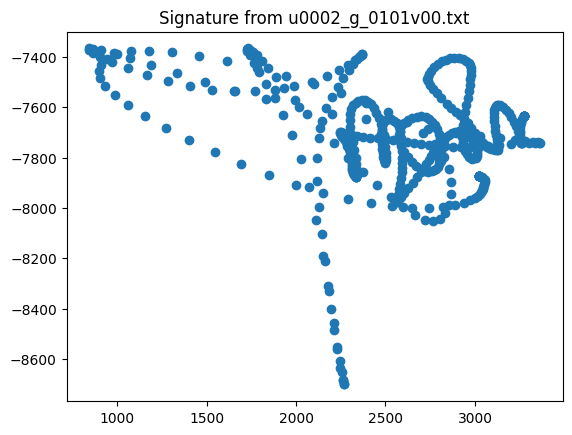

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sigma_lognormal.plotting import show_plot

# 1. Point this at your folder 
folder = r"C:\Users\kingr\HCLTech_project\Data\20U"

# 2. Gather all .txt filenames and sort them (so “first 10” is deterministic)
all_files = [
    fname for fname in os.listdir(folder)
    if fname.lower().endswith(".txt")
]
all_files.sort()       # e.g. ["u0001_g_0101v00.txt", "u0002_g_0101v00.txt", …]

# 3. Take the first 10 files (or fewer, if less than 10 exist) 
files_to_process = all_files[:10]

# 4. Loop through these 10 files, parse each into a NumPy array, preprocess
signals = []
for fname in files_to_process:
    fullpath = os.path.join(folder, fname)
    
    coords = []
    with open(fullpath, "r", encoding="utf-8", errors="ignore") as f:
        # (a) Skip line 1 (point count)
        header = f.readline().strip()    # e.g. "271"
        
        # (b) Read each subsequent line → split → grab x, y, t
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            
            x = float(parts[0])
            y = float(parts[1])
            t = float(parts[2]) if len(parts) >= 3 else 0.0
            coords.append([x, y, t])
    
    arr = np.array(coords)  # shape = (N_points, 3)
    
    # (c) Call preprocess: if preprocess expects (x,y,t), pass arr;
    #     if it only expects (x,y), do preprocess(arr[:, :2]) instead.
    signal_obj = preprocess(arr)
    signals.append(signal_obj)

#  5. Now `signals` is a list of 10 “signal” objects 
print(f"Loaded and preprocessed {len(signals)} signatures.")

# 6. (Optional) Plot the first one to verify 
if signals:
    plt.title(f"Signature from {files_to_process[0]}")
    show_plot("signals", [signals[0]])


speed-profile plotting: looping over all 10 files and viewing their speed profiles

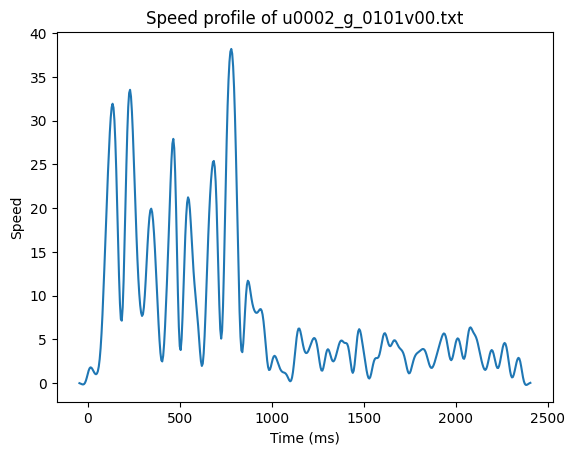

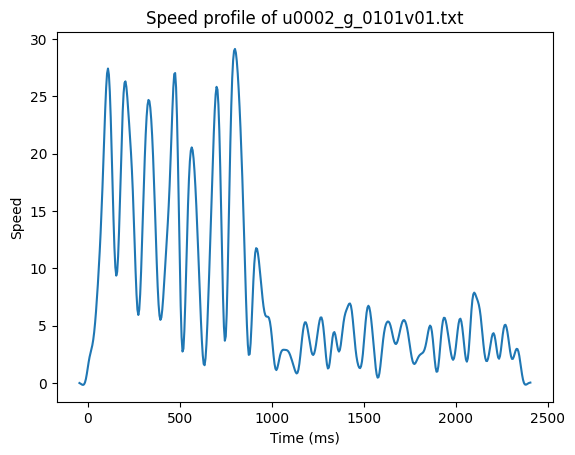

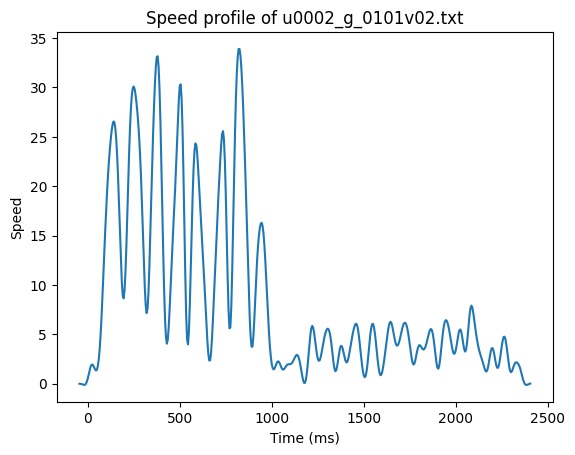

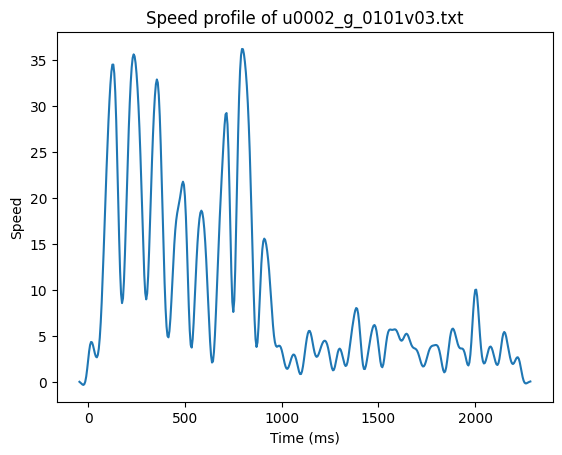

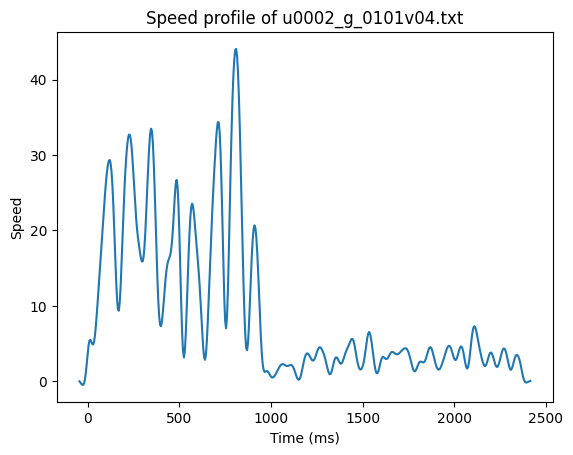

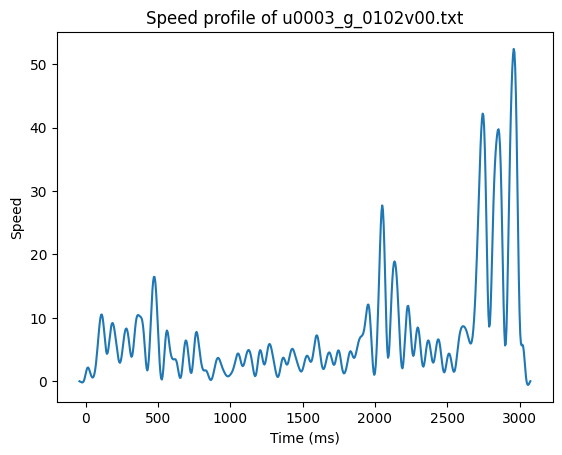

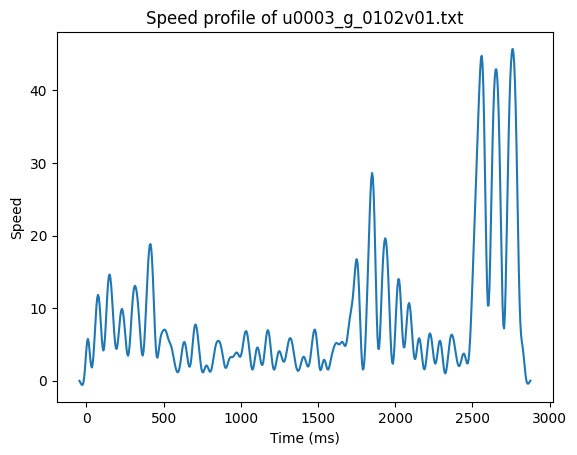

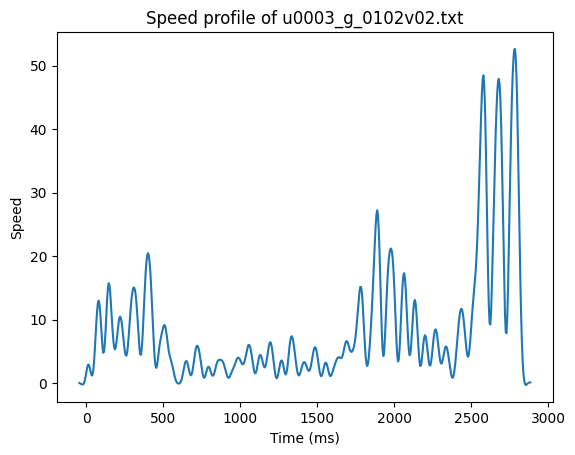

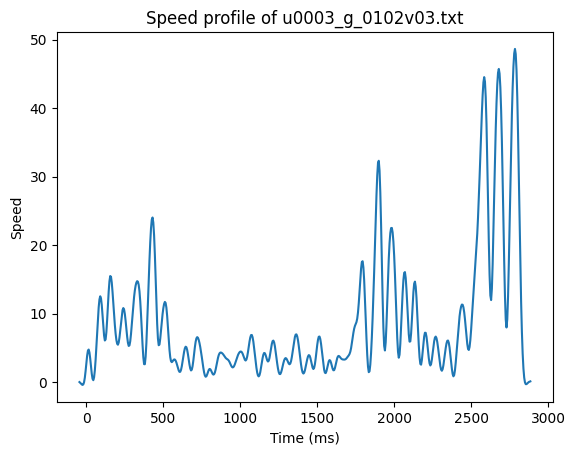

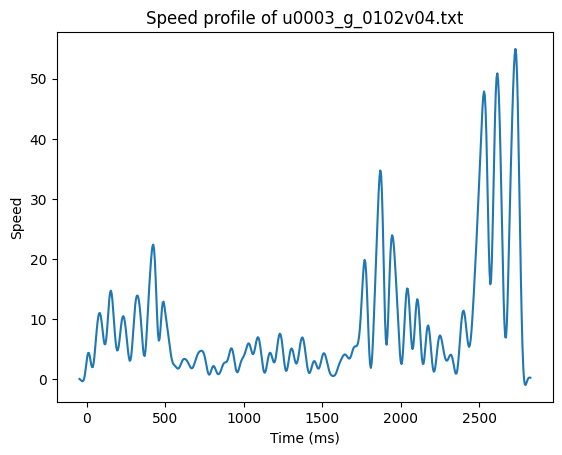

In [6]:
for i, sig in enumerate(signals):
    plt.figure()
    plt.title(f"Speed profile of {files_to_process[i]}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Speed")
    show_plot("speeds", [sig], should_scatter=False)


Extracting candidate lognormals (handstroke proposals)

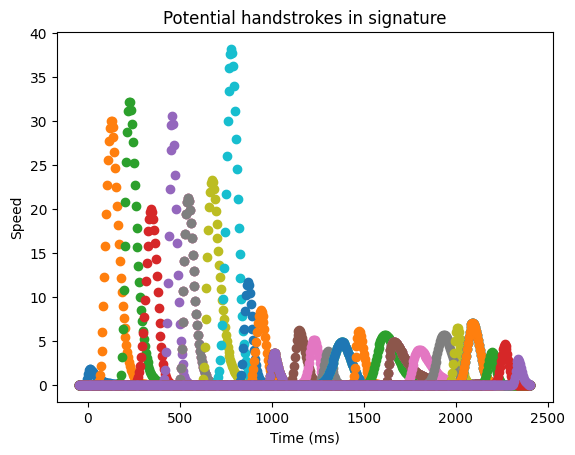

In [7]:
from sigma_lognormal.speed_extract import extract_all_lognormals

# for the first signature:
lognormals = extract_all_lognormals(signals[0])

# Plot all candidate strokes on top of the speed profile
plt.figure()
plt.title("Potential handstrokes in signature")
plt.xlabel("Time (ms)")
plt.ylabel("Speed")
lgn_signals = [lgn.signal(signals[0].time) for lgn in lognormals]
show_plot("speeds", lgn_signals)


In [8]:
from sigma_lognormal.beam_search import BeamSearch
from sigma_lognormal.action_plan import ActionPlan

top_k = 2
snr_threshold = 25
max_strokes = 30

# We use beam search to find the best set of handstrokes
search = BeamSearch(signals[0],top_k,snr_threshold,max_strokes)

In [9]:
import json

# To re‐run from scratch (set use_cached = False):
use_cached = False

if not use_cached:
    out_plan, snr_plot = search.search()
    # (Optionally save with json.dump)
else:
    out_plan = ActionPlan.from_json(json.load(open("data/cached_plan.json")))

out_signal = out_plan.signal(signals[0].time)

 97%|█████████▋| 29/30 [00:25<00:00,  1.14it/s]


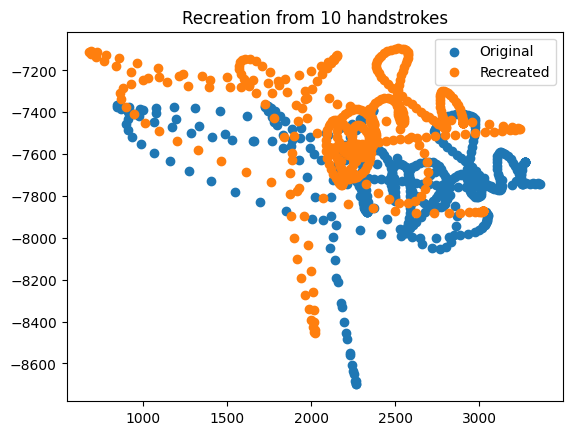

In [10]:
small_plan = out_plan.sub_plan(10)
small_signal = small_plan.signal(signals[0].time)

# plot original vs recreated signal
plt.figure()
plt.title("Recreation from "+str(len(small_plan.strokes))+" handstrokes")
show_plot("signals", [signals[0], out_signal], legend=["Original", "Recreated"])

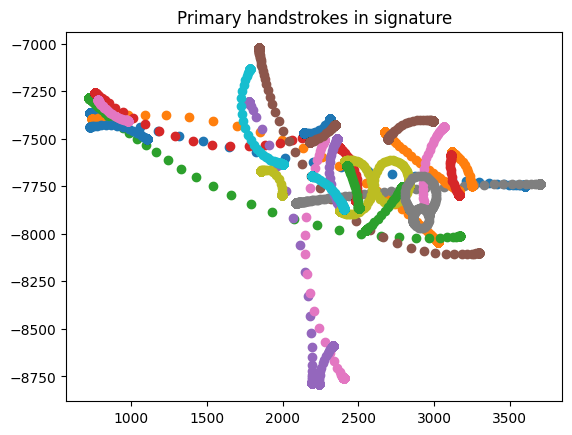

In [11]:
# Move a stroke to its position in the signature
def get_modified_stroke(stroke):
    base_signal = stroke.signal(signals[0].time)
    max_speed_time = stroke.time_of_max_speed()
    base_position_of_max_speed = stroke.position(max_speed_time)
    max_speed_signal_index = signals[0].find_closest_time(max_speed_time)
    real_position_of_max_speed = signals[0].position[max_speed_signal_index]

    position_offset = real_position_of_max_speed-base_position_of_max_speed
    return base_signal + position_offset

threshold = 150 # pixels in length

stroke_signals = [get_modified_stroke(stroke) for stroke in out_plan.strokes if stroke.D > threshold]

plt.title("Primary handstrokes in signature")
show_plot("signals",[*stroke_signals])

Now, we animate the signature (note: this visualization might be broken in the GitHub viewer).

In [17]:
"""from sigma_lognormal.plotting import animate_plot

# Note: animate_plot may not render in static viewers, but works in Jupyter

animate_plot(
    "signals",
    [signals[0], out_signal],
    title="Re-creation of signature",
    x_label="X position",
    y_label="Y position",
    legend=["Original", "Re-created"]
)"""



'from sigma_lognormal.plotting import animate_plot\n\n# Note: animate_plot may not render in static viewers, but works in Jupyter\n\nanimate_plot(\n    "signals",\n    [signals[0], out_signal],\n    title="Re-creation of signature",\n    x_label="X position",\n    y_label="Y position",\n    legend=["Original", "Re-created"]\n)'

*Computing Velocity Metric and Scatter Plot Implementation*


In [13]:
def compute_velocity(signal):
    """
    Compute velocity profile from position data.
    signal: Preprocessed signal object from sigma-lognormal
    Returns: velocities (array), avg_velocity (float)
    """
    # Extract positions and timestamps
    x = signal.position[:, 0]
    y = signal.position[:, 1]
    t = signal.time
    
    # Calculate differences
    dx = np.diff(x)
    dy = np.diff(y)
    dt = np.diff(t)
    
    # Avoid division by zero
    dt = np.where(dt == 0, 1e-5, dt)
    
    # Compute instantaneous velocity
    velocities = np.sqrt(dx**2 + dy**2) / dt
    
    # Pad to match original length
    velocities = np.concatenate(([0], velocities))
    
    # Compute average velocity (ignore zeros)
    avg_velocity = np.mean(velocities[velocities > 0])
    
    return velocities, avg_velocity



Alternative Approach: Velocity-Based Stroke Detection (when lognormal fails)

In [14]:
def fallback_stroke_detection(sig, min_peaks=3):
    """Velocity-based stroke detection when lognormal fails"""
    from scipy.signal import find_peaks
    
    velocities, _ = compute_velocity(sig)
    
    # Find peaks in velocity profile
    peaks, properties = find_peaks(velocities, height=min_peak_height, distance=5)
    
    if len(peaks) < min_peaks:
        print("  Insufficient velocity peaks - using entire signal")
        return [{
            't0': sig.time[0],
            'mu': np.log(len(sig.time)/10),  # Approximate duration
            'sigma': 0.7,
            'D': np.max(velocities)*50  # Amplitude estimate
        }]
    
    # Create stroke parameters based on velocity peaks
    strokes = []
    for peak_idx in peaks:
        t_peak = sig.time[peak_idx]
        v_peak = velocities[peak_idx]
        
        # Estimate stroke parameters
        stroke = {
            't0': t_peak - 50,  # start 50ms before peak
            'mu': np.log(30),    # fixed average duration
            'sigma': 0.5 + np.random.uniform(-0.1, 0.1),  # slight variation
            'D': v_peak * 40    # amplitude proportional to peak velocity
        }
        strokes.append(stroke)
    
    return strokes

def reconstruct_from_fallback(strokes, time_array):
    """Create synthetic signal from fallback stroke parameters"""
    from sigma_lognormal.lognormal import Lognormal
    from sigma_lognormal.signals import Signal
    
    # Create dummy lognormal objects
    lognormal_objs = []
    for stroke in strokes:
        # Create lognormal with fallback parameters
        lgn = Lognormal(
            t0=stroke['t0'],
            mu=stroke['mu'],
            sigma=stroke['sigma'],
            D=stroke['D'],
            theta=0  # default angle
        )
        lognormal_objs.append(lgn)
    
    # Create reconstructed signal
    position = np.zeros((len(time_array), 2))
    for lgn in lognormal_objs:
        # Get velocity profile for this stroke
        v = lgn.signal(time_array)
        # Integrate velocity to position (simplified)
        for i in range(1, len(time_array)):
            dt = time_array[i] - time_array[i-1]
            position[i] += position[i-1] + v[i] * dt
    
    return Signal(
        time=time_array,
        position=position,
        velocity=v,  # approximation
        raw_position=position
    )

Velocity Analysis for All Signatures

In [15]:
# Lists to store results
all_original_velocities = []
all_recreated_velocities = []
avg_velocities = []

# Configure stroke extraction parameters
top_k = 2
snr_threshold = 25  # Lower is more sensitive
max_strokes = 30
min_peak_height = 0.01  # Lower threshold for weak signatures

for i, sig in enumerate(signals):
    print(f"\nProcessing {files_to_process[i]}...")
    
    # 1. Compute original velocity
    orig_velocities, orig_avg = compute_velocity(sig)
    all_original_velocities.append(orig_velocities)
    
    # 2. Compute recreated velocity - WITH ERROR HANDLING
    try:
        # Attempt with lower peak threshold
        lognormals = extract_all_lognormals(sig, peak_height_threshold=min_peak_height)
        
        # Debug: Show found strokes
        print(f"  Found {len(lognormals)} candidate strokes")
        
        if len(lognormals) == 0:
            raise ValueError("No strokes detected")
            
        search = BeamSearch(sig, top_k, snr_threshold, max_strokes)
        out_plan, _ = search.search()
        out_signal = out_plan.signal(sig.time)
        
        rec_velocities, rec_avg = compute_velocity(out_signal)
        all_recreated_velocities.append(rec_velocities)
        
        # 3. Store metrics
        avg_velocities.append((orig_avg, rec_avg))
        print(f"  Original Avg Velocity: {orig_avg:.2f} px/ms")
        print(f"  Recreated Avg Velocity: {rec_avg:.2f} px/ms")

    except Exception as e:
        print(f"  ERROR in recreation: {str(e)}")
        print("  Using original as fallback")
        
        # Fallback: Use original signal as recreation
        all_recreated_velocities.append(orig_velocities.copy())
        avg_velocities.append((orig_avg, orig_avg))


Processing u0002_g_0101v00.txt...
  Found 35 candidate strokes


 97%|█████████▋| 29/30 [00:24<00:00,  1.17it/s]


  Original Avg Velocity: 7.93 px/ms
  Recreated Avg Velocity: 7.57 px/ms

Processing u0002_g_0101v01.txt...
  Found 29 candidate strokes


 97%|█████████▋| 29/30 [00:22<00:00,  1.27it/s]


  Original Avg Velocity: 8.06 px/ms
  Recreated Avg Velocity: 7.51 px/ms

Processing u0002_g_0101v02.txt...
  Found 30 candidate strokes


 97%|█████████▋| 29/30 [00:24<00:00,  1.19it/s]


  Original Avg Velocity: 8.77 px/ms
  Recreated Avg Velocity: 8.18 px/ms

Processing u0002_g_0101v03.txt...
  Found 26 candidate strokes


 97%|█████████▋| 29/30 [00:28<00:00,  1.03it/s]


  Original Avg Velocity: 9.52 px/ms
  Recreated Avg Velocity: 8.76 px/ms

Processing u0002_g_0101v04.txt...
  Found 32 candidate strokes


 97%|█████████▋| 29/30 [00:21<00:00,  1.35it/s]


  Original Avg Velocity: 9.37 px/ms
  Recreated Avg Velocity: 8.78 px/ms

Processing u0003_g_0102v00.txt...
  Found 40 candidate strokes


 97%|█████████▋| 29/30 [00:27<00:00,  1.04it/s]


  Original Avg Velocity: 7.67 px/ms
  Recreated Avg Velocity: 7.13 px/ms

Processing u0003_g_0102v01.txt...
  Found 45 candidate strokes


 97%|█████████▋| 29/30 [00:27<00:00,  1.05it/s]


  Original Avg Velocity: 8.52 px/ms
  Recreated Avg Velocity: 7.81 px/ms

Processing u0003_g_0102v02.txt...
  Found 40 candidate strokes


 97%|█████████▋| 29/30 [00:23<00:00,  1.24it/s]


  Original Avg Velocity: 8.90 px/ms
  Recreated Avg Velocity: 8.08 px/ms

Processing u0003_g_0102v03.txt...
  Found 38 candidate strokes


 97%|█████████▋| 29/30 [00:32<00:01,  1.11s/it]

  Original Avg Velocity: 9.14 px/ms
  Recreated Avg Velocity: 8.50 px/ms

Processing u0003_g_0102v04.txt...
  ERROR in recreation: list index out of range
  Using original as fallback


 97%|█████████▋| 29/30 [00:30<00:01,  1.06s/it]


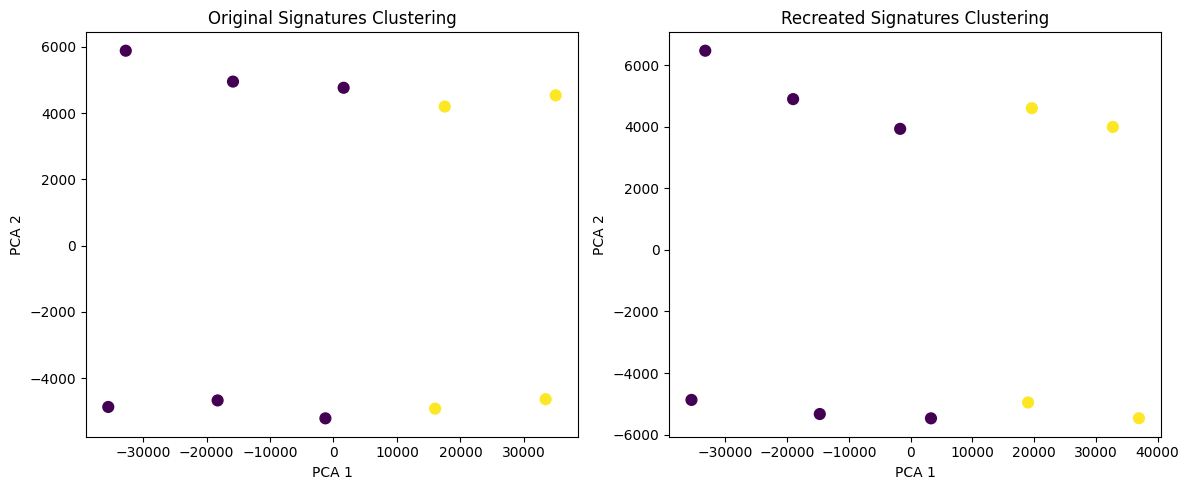

In [16]:
# Clustering and Visualization for Original and Recreated Signatures

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Helper: flatten a signal's position into a 1D vector (for clustering)
def flatten_signal(sig, n_points=100):
    # Resample to fixed number of points for fair comparison
    from scipy.interpolate import interp1d
    t = sig.time
    pos = sig.position
    t_new = np.linspace(t[0], t[-1], n_points)
    interp = interp1d(t, pos, axis=0, fill_value="extrapolate")
    pos_new = interp(t_new)
    return pos_new.flatten()

# Prepare feature arrays
n_points = 100
original_features = [flatten_signal(sig, n_points) for sig in signals]

# For recreated signals, use the same process as in your velocity analysis
recreated_features = []
for i, sig in enumerate(signals):
    try:
        lognormals = extract_all_lognormals(sig, peak_height_threshold=min_peak_height)
        if len(lognormals) == 0:
            raise ValueError("No strokes detected")
        search = BeamSearch(sig, top_k, snr_threshold, max_strokes)
        out_plan, _ = search.search()
        out_signal = out_plan.signal(sig.time)
        recreated_features.append(flatten_signal(out_signal, n_points))
    except Exception:
        # Fallback: use original
        recreated_features.append(flatten_signal(sig, n_points))

# Stack into arrays
original_features = np.vstack(original_features)
recreated_features = np.vstack(recreated_features)

# Clustering (e.g., 2 clusters)
n_clusters = 2
kmeans_orig = KMeans(n_clusters=n_clusters, random_state=42).fit(original_features)
kmeans_re = KMeans(n_clusters=n_clusters, random_state=42).fit(recreated_features)

# Reduce to 2D for plotting
pca = PCA(n_components=2)
orig_2d = pca.fit_transform(original_features)
re_2d = pca.transform(recreated_features)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Original Signatures Clustering")
plt.scatter(orig_2d[:, 0], orig_2d[:, 1], c=kmeans_orig.labels_, cmap='viridis', s=60)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.subplot(1, 2, 2)
plt.title("Recreated Signatures Clustering")
plt.scatter(re_2d[:, 0], re_2d[:, 1], c=kmeans_re.labels_, cmap='viridis', s=60)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()